In [ ]:
#Author:    Rui Ding
#Created:   04.07.2020

In [1]:
import pandas as pd
import datetime
import re
import urllib
def yahoo_Finance_Read(name, startDate, endDate, interval):
    #Read stock prices for a single stock
    if (interval.lower()=="weekly"):
        period = "1wk"
    elif (interval.lower()=="daily"):
        period = "1d"
    elif (interval.lower()=="monthly"):
        period = "1mo"
    else:
        raise ValueError("Invalid Period!")
    startD = str(int((datetime.datetime.strptime(startDate, "%m/%d/%Y") - datetime.datetime(1970, 1, 1)).total_seconds()))
    endD = str(int((datetime.datetime.strptime(endDate, "%m/%d/%Y") - datetime.datetime(1970, 1, 1)).total_seconds()))
    url = "https://finance.yahoo.com/quote/"+ name +"/history?period1=" + startD + "&period2=" + endD + "&interval=" + period + "&filter=history&frequency=" + period
    temp = urllib.request.urlopen(url).read().decode()
    tempsplit = temp.split('{"date":')
    lst = []
    line = tempsplit[-1].split('}')[0]
    if 'SPLIT' not in line:
        linedata = ','.join(re.split(',|:|}', line)[0:13:2])
        linetmp = linedata.split(',')
        datenum = int(linetmp[0])
        linetmp[0] = datetime.datetime.fromtimestamp(datenum).strftime("%m/%d/%Y")
        linedata = ','.join(linetmp)
        lst.append(linetmp)
    for line in reversed(tempsplit[2:-1]):
        if 'SPLIT' in line:
            continue
        linedata = ','.join(re.split(',|:|}', line)[0:13:2])
        linetmp = linedata.split(',')
        datenum = int(linetmp[0])
        linetmp[0] = datetime.datetime.fromtimestamp(datenum).strftime("%m/%d/%Y")
        linedata = ','.join(linetmp)
        lst.append(linetmp)
    df = pd.DataFrame(lst, columns=['date','open','high','low','close','volume','adjclose'])
    df['date'] = pd.to_datetime(df['date'],format="%m/%d/%Y")
    if (interval.lower()=="weekly"):
        while(df['date'][:1][0].weekday()!=4):
            df['date'] = df['date'] + datetime.timedelta(1)
        if((df['date'].tail(1) > datetime.datetime.today()).bool()):
            df = df[:-1]
   
    return df

In [6]:
def yahoo_Finance_read_all(names,start,end,freq):
    #Read stock adjusted close prices for a list of stocks
    Data = None
    flag = False
    for i in range(len(names)):
        name = names[i]
        print(name)
        try:
            df = yahoo_Finance_Read(name,start,end,freq)
            dates=df['date'].values
            if not flag:
                Data = np.zeros((len(dates),len(names)))
                flag = True
            C=df['adjclose'].values
            Data[:,i] = C
        except:
            pass
    return Data

In [7]:
#Get Dow Jones 30 list
l = pd.read_table('Dow Jones 30.txt',header=None)
list_stocks=l.values.reshape(1,-1)[0]

In [10]:
import datetime
import numpy as np
start = datetime.datetime(2014, 4, 1).strftime('%m/%d/%Y')
end = datetime.datetime(2020, 4, 1).strftime('%m/%d/%Y')
#Reading in adjusted close for all Dow Jones 30 stocks
Data = yahoo_Finance_read_all(list_stocks,start,end,'daily')

AXP
AAPL
BA
CAT
CSCO
CVX
XOM
GS
HD
IBM
INTC
JNJ
KO
JPM
MCD
MMM
MRK
MSFT
NKE
PFE
PG
TRV
UNH
RTX
VZ
V
WBA
WMT
DIS
DOW


In [47]:
print(Data.shape)
Data_ = Data[:,:-1].copy()
daily_change = (Data_[1:,:]-Data_[:-1,:])/Data_[:-1:]
np.save('DJ_data.npy',daily_change)

(1511, 30)


In [48]:
data = np.load('DJ_data.npy')
data.shape

(1510, 29)

In [49]:
data

array([[-0.00593806,  0.00166164,  0.00077996, ...,  0.00789915,
         0.00534067,  0.00122586],
       [ 0.00641606, -0.00693058,  0.00366306, ...,  0.01115268,
         0.00362828,  0.00024493],
       [-0.01989445, -0.01293598, -0.01087143, ..., -0.01550121,
        -0.00193701, -0.01542428],
       ...,
       [-0.04887979, -0.04140225, -0.10274164, ..., -0.03656664,
        -0.00218537, -0.08504175],
       [ 0.01735595,  0.02853795, -0.06000001, ...,  0.02636363,
         0.05119548,  0.03526972],
       [-0.05162288, -0.00204075, -0.02061991, ...,  0.01306466,
        -0.01362965, -0.03206417]])

In [51]:
#Read in index data
dj = yahoo_Finance_Read('^DJI',start,end,'daily')

In [60]:
adj_c = dj['adjclose'].values.astype('float') 

In [62]:
dj_ret = (adj_c[1:]-adj_c[:-1])/adj_c[:-1]

In [64]:
np.save('DJI_ret.npy',dj_ret)

In [79]:
#Combine data
Full = np.zeros((1510,30))
Full[:,1:30] = data
Full[:,0] = dj_ret

In [80]:
np.save('Full_ret.npy',Full)

In [81]:
#Calculate cumulative returns
Cum_ret = Full.copy()
for i in range(1,len(Full)):
    Cum_ret[i,:] = Cum_ret[i,:]+Cum_ret[i-1,:]
Drawdown = np.zeros((Cum_ret.shape))

In [82]:
#Calculate drawdowns
for i in range(len(Drawdown)):
    for j in range(len(Drawdown[0])):
        hist = Cum_ret[:i+1,j]
        Drawdown[i,j] = max(hist)-Cum_ret[i,j]

In [92]:
np.save('Drawdown.npy',Drawdown)

In [89]:
names = np.array(['DJI']+list(list_stocks[:-1]))
np.save('list_names.npy',names)

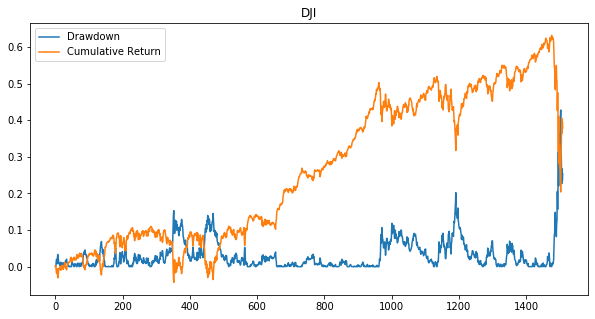

In [91]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5))
plt.title(names[0])
plt.plot(Drawdown[:,0],label='Drawdown')
plt.plot(Cum_ret[:,0],label='Cumulative Return')
plt.legend()